[From official `scikit-learn` documentation](http://scikit-learn.org/stable/auto_examples/model_selection/plot_grid_search_digits.html)<br>
Adapted by Claudio Sartori

# Classification with Decision Tree - hyperparameter tuning (__model selection__) with Grid Search and Cross Validation

We use here the Decision Tree and the standard `CrossValidation`, then find the best hyperparameter setting through _grid search_


### Workflow
1. download the data
1. data exploration
1. drop the useless data (if any)
1. separe the predicting attributes X from the class attribute y
1. split X and y into training and test
    - set a variable `target` with the column name of the target
1. single run with default parameters
    - initialise a estimator with the DecisionTreeClassifier
    - fit the estimator with the training part of X
    - show the tree structure
        - in particular, observe the maximum depth of the tree, this will be used in choosing the range for the `max_depth` hyperparameter
    - predict the y values with the fitted estimator and the train data
        - compare the predicted values with the true ones and compute the accuracy on the training set 
    - predict the y values with the fitted estimator and the test data
        - compare the predicted values with the true ones and compute the accuracy on the test set
        - this will be our baseline

## Model selection

- the *train* part will be used for training and _cross-validation_ (i.e. for *development*)
- the *test* part will be used for test (i.e. for *evaluation*)
- the fraction of test data will be __train_size__ (a value of your choice between 0.2 and 0.5)
- the function `GridSearchCV` iterates a cross validation experiment to __train__ and __validate__ a model with different combinations of paramater values
- for each parameter we set a list of values to test, the `GridSearchCV` function will generate all the combinations
- we will make several experiments with the optimisation of different *score function* 
    - e.g. `accuracy_score`, `precision_score`, `recall_score`, `f1_score`, see this [page](http://scikit-learn.org/stable/modules/classes.html#module-sklearn.metrics) for reference
    - the output is a dictionary containing 
        - the set of parameters which maximize the score 
        - the test scores


## Highlights

- `tree_` attribute in the fitted decision tree
    - contains some useful information, such as `max_depth`
- `GridSearchCV`
    - implements *cross validation*, needs 
        - a *score to be optimized*
        - *ranges* of the hyperparameters to be optimized, the *parameters grid*
    - sets the values for `best_params_` and `best_estimator_`
- `classification_report`
- `ConfusionMatrixDisplay`



In [1]:
import warnings
warnings.filterwarnings('ignore') # uncomment this line to suppress warnings
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

### Prepare the environment
Import libraries

Load the dataset `winequality-red-wi.csv`

Set the training set size and the random state

In [39]:
url = 'winequality-red.csv'
sep = ';'
# adjust the line below, if necessary
df = pd.read_csv(url, sep = sep)

df

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,7.4,0.700,0.00,1.9,0.076,11.0,34.0,0.99780,3.51,0.56,9.4,5
1,7.8,0.880,0.00,2.6,0.098,25.0,67.0,0.99680,3.20,0.68,9.8,5
2,7.8,0.760,0.04,2.3,0.092,15.0,54.0,0.99700,3.26,0.65,9.8,5
3,11.2,0.280,0.56,1.9,0.075,17.0,60.0,0.99800,3.16,0.58,9.8,6
4,7.4,0.700,0.00,1.9,0.076,11.0,34.0,0.99780,3.51,0.56,9.4,5
...,...,...,...,...,...,...,...,...,...,...,...,...
1594,6.2,0.600,0.08,2.0,0.090,32.0,44.0,0.99490,3.45,0.58,10.5,5
1595,5.9,0.550,0.10,2.2,0.062,39.0,51.0,0.99512,3.52,0.76,11.2,6
1596,6.3,0.510,0.13,2.3,0.076,29.0,40.0,0.99574,3.42,0.75,11.0,6
1597,5.9,0.645,0.12,2.0,0.075,32.0,44.0,0.99547,3.57,0.71,10.2,5


Read the data into a dataframe and show the size

In [6]:
df.shape

(1599, 12)

Have a quick look to the data.
- use the `.head()` function to see column names and some data
- use other exploration methods if you want

In [7]:
df.head()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5
1,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.9968,3.20,0.68,9.8,5
2,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.9970,3.26,0.65,9.8,5
3,11.2,0.28,0.56,1.9,0.075,17.0,60.0,0.9980,3.16,0.58,9.8,6
4,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5


Show an histogram of the target labels frequencies (hint: use the `value_counts` method)

<AxesSubplot:xlabel='quality'>

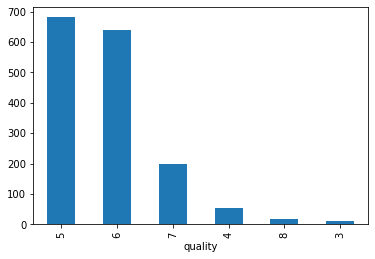

In [32]:
df.value_counts("quality").plot(kind="bar")


#### Split the data into the __predicting values__ `X` and the __target__ `y`
Drop also the columns which are not relevant for training a classifier, if any

The method "drop" of dataframes allows to drop either rows or columns
- the "axis" parameter chooses between dropping rows (axis=0) or columns (axis=1)

In [40]:
target="quality"
X = df.drop(target, axis=1)
X

y = df[target]
y

0       5
1       5
2       5
3       6
4       5
       ..
1594    5
1595    6
1596    6
1597    5
1598    6
Name: quality, Length: 1599, dtype: int64

### Prepare the baseline: holdout method

In [102]:
from sklearn.model_selection import train_test_split
train_size = 0.67
random_state = 42 # any positive integer is acceptable, it is necessary for **reproducibility

Xtrain, Xtest, ytrain, ytest = train_test_split(X, y, random_state= random_state, train_size = train_size)
print(Xtrain.shape, Xtest.shape, ytrain.shape, ytest.shape)

print(f"There are {Xtrain.shape[0]} samples in the training dataset")
print(f"There are {Xtest.shape[0]} samples in the test dataset")
print(f"Each sample has {Xtrain.shape[1]} features")


(1071, 11) (528, 11) (1071,) (528,)
There are 1071 samples in the training dataset
There are 528 samples in the test dataset
Each sample has 11 features


- Initialize an estimator with the required model generator `tree.DecisionTreeClassifier(random_state = random_state)`
- Fit the estimator on the train data and target

In [103]:
from sklearn.tree import DecisionTreeClassifier                  # 1. choose model class
model = DecisionTreeClassifier(random_state=random_state)       # 2. instantiate model
model.fit(Xtrain, ytrain)                                     # 3. fit model to data
ytrain_dt = model.predict(Xtrain)                       

Let's see how it works on test data, and, comparing with the result on training data, see if you can suspect *overfitting*
- use the fitted estimator to predict using the test features
- compute the accuracy and store it on a variable for the final summary
- store the maximum depth of the tree, for later use 
    - `fitted_max_depth = estimator.tree_.max_depth`
- store the range of the parameter which will be used for tuning
    - `parameter_values = range(1,fitted_max_depth+1)`
- print the accuracy on the test set and the maximum depth of the tree

In [105]:
from sklearn.metrics import accuracy_score
accuracy_train = accuracy_score(ytrain, ytrain_dt)
print("The accuracy on training set is {0:.2f}%".format(accuracy_train * 100))   # for training set

ytest_dt = model.predict(Xtest)                                                  # 4. predict on new (test) data
accuracy_test = accuracy_score(ytest, ytest_dt)
print("The accuracy on test set is {0:.2f}%".format(accuracy_test * 100))

fitted_max_depth = model.tree_.max_depth
print(f"The maximum depth of the tree fitted on X_train is {fitted_max_depth}")

The accuracy on training set is 100.00%
The accuracy on test set is 55.11%
The maximum depth of the tree fitted on X_train is 18


Prepare the decision tree parameters and the scores 

In [106]:
# Set the parameters to be explored during the rounds of cross-validation
tuned_param_dt = [{'max_depth': [*range(1,fitted_max_depth+1)]
                , 'criterion' : ['entropy', 'gini']
                , 'class_weight' : [None, 'balanced']}]

# Set the different scores that will be optimised
scores = ['accuracy'
        , 'precision_macro'
        , 'recall_macro'
        , 'f1_macro']

### Loop on scores
- iterate varying the score function
    - fit the estimator using the training data
        - the resulting model will be the best one according to the current score function
    - print the best estimator
    - print the best score
    - predict the target for the test set using the `.predict` method
    - print the `classification report`
    - display the confusion matrix with `ConfusionMatrixDisplay`

Tuning hyperparameters for accuracy
Best estimator: {'class_weight': None, 'criterion': 'gini', 'max_depth': 12}
Best score: 60.79%

              precision    recall  f1-score   support

           3       0.00      0.00      0.00         2
           4       0.00      0.00      0.00        19
           5       0.66      0.65      0.66       217
           6       0.57      0.54      0.56       213
           7       0.43      0.51      0.47        70
           8       0.29      0.29      0.29         7

    accuracy                           0.56       528
   macro avg       0.32      0.33      0.33       528
weighted avg       0.56      0.56      0.56       528



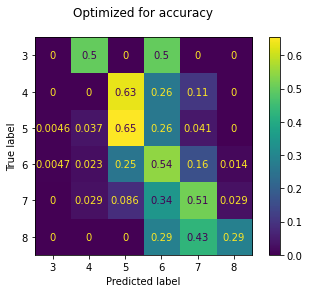

Tuning hyperparameters for precision_macro
Best estimator: {'class_weight': None, 'criterion': 'gini', 'max_depth': 10}
Best score: 33.93%

              precision    recall  f1-score   support

           3       0.00      0.00      0.00         2
           4       0.00      0.00      0.00        19
           5       0.67      0.72      0.69       217
           6       0.58      0.55      0.56       213
           7       0.44      0.47      0.46        70
           8       0.00      0.00      0.00         7

    accuracy                           0.58       528
   macro avg       0.28      0.29      0.29       528
weighted avg       0.57      0.58      0.57       528



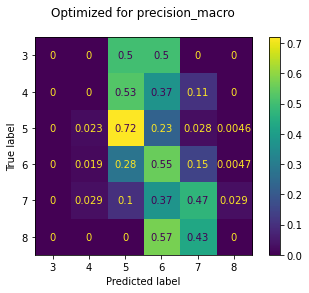

Tuning hyperparameters for recall_macro
Best estimator: {'class_weight': None, 'criterion': 'gini', 'max_depth': 14}
Best score: 34.48%

              precision    recall  f1-score   support

           3       0.00      0.00      0.00         2
           4       0.00      0.00      0.00        19
           5       0.67      0.64      0.65       217
           6       0.57      0.58      0.58       213
           7       0.43      0.51      0.47        70
           8       0.25      0.14      0.18         7

    accuracy                           0.57       528
   macro avg       0.32      0.31      0.31       528
weighted avg       0.56      0.57      0.57       528



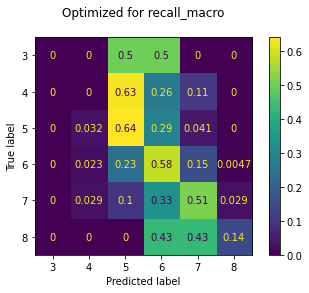

Tuning hyperparameters for f1_macro
Best estimator: {'class_weight': 'balanced', 'criterion': 'entropy', 'max_depth': 18}
Best score: 33.77%

              precision    recall  f1-score   support

           3       0.00      0.00      0.00         2
           4       0.17      0.11      0.13        19
           5       0.67      0.61      0.64       217
           6       0.53      0.59      0.56       213
           7       0.49      0.51      0.50        70
           8       0.33      0.29      0.31         7

    accuracy                           0.56       528
   macro avg       0.37      0.35      0.36       528
weighted avg       0.57      0.56      0.56       528



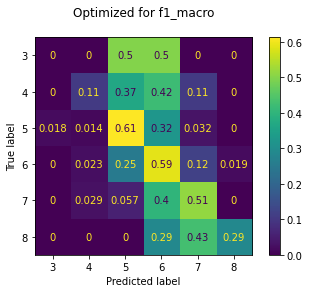

In [113]:
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import ConfusionMatrixDisplay, classification_report
 
for s in scores:
    print("=================================")
    print(f"Tuning hyperparameters for {s}")
    grid = GridSearchCV(model, param_grid=tuned_param_dt, scoring=s)
    fitted_grid = grid.fit(Xtrain, ytrain)                                            # 3. fit model to data
    #grid.fit(Xtrain, ytrain)

    print(f"Best estimator: {fitted_grid.best_params_}")
    print("Best score: {0:.2f}%\n".format(fitted_grid.best_score_*100))
    
    ytest_pred_gr = grid.predict(Xtest)                                     # 4. predict on new (test) data
    print(classification_report(y_true=ytest, y_pred=ytest_pred_gr))
    ConfusionMatrixDisplay.from_predictions(y_true=ytest, y_pred=ytest_pred_gr, normalize='true')
    plt.title(f"Optimized for {s}\n ")
    plt.show()                                                               



In [13]:
clf.best_params_

{'class_weight': None, 'criterion': 'gini', 'max_depth': 10}